In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib
import time
import numpy as np
%matplotlib inline

import pandas as pd
pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 100


In [2]:
#Model File Directory
WORK_DIR = '/var/spark/ml_files/'

#Label Keys
LABEL = "success"

MODEL_TYPE = "ML-ECO"





In [3]:
from cassandra.cluster import Cluster
cassandra_endpoint = '10.62.1.118'
cluster = Cluster([cassandra_endpoint])


In [4]:
TRAINING_DATA_PATH = WORK_DIR + 'eco_2019_06.csv'
eco = pd.read_csv(TRAINING_DATA_PATH)
eco.shape

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(136989, 48)

In [5]:
date_increment_bin_dict = None
added_years_bin_dict = None

DATE_INCREMENT_BIN_PATH = WORK_DIR + 'date_increment_bin_2019_Q1.csv'
ADDED_YEARS_BIN_PATH = WORK_DIR + 'added_years_bin_2019_Q1.csv'

if DATE_INCREMENT_BIN_PATH:
    date_increment_bin = pd.read_csv(DATE_INCREMENT_BIN_PATH)
    date_increment_bin.drop(columns=['Unnamed: 0'], inplace=True)
    date_increment_bin['bin'] = date_increment_bin['bin'].apply(str).str.replace('.0', '', regex=False)
    date_increment_bin['date_increment'] = date_increment_bin['date_increment'].apply(str).str.replace('.0', '', regex=False)
    date_increment_bin_dict = date_increment_bin.set_index(['bin', 'date_increment'])['success_rate'].T.to_dict()

    
if  ADDED_YEARS_BIN_PATH:
    added_years_bin = pd.read_csv(ADDED_YEARS_BIN_PATH)
    added_years_bin.drop(columns=['Unnamed: 0'], inplace=True)
    added_years_bin['bin'] = added_years_bin['bin'].apply(str).str.replace('.0', '', regex=False)
    added_years_bin['added_expiry_years'] = added_years_bin['added_expiry_years'].apply(str).str.replace('.0', '', regex=False)
    added_years_bin_dict = added_years_bin.set_index(['bin', 'added_expiry_years'])['success_rate'].T.to_dict()



In [6]:
eco = eco[~eco['date_increment'].isna()]
eco = eco[~eco['added_expiry_years'].isna()]
eco.loc[eco.added_expiry_years == 'STALE', 'added_expiry_years'] = 0
eco['cc_expiration_date'] = eco['cc_expiration_date'].apply(str)
eco.shape

(115726, 48)

In [7]:
original_size = len(eco)
fail_size = eco[LABEL].value_counts(normalize=True)[0.0]
success_size =  eco[LABEL].value_counts(normalize=True)[1.0]

In [8]:
#import for training
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn import linear_model
from sklearn import tree
from sklearn import cross_validation
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn.dummy import DummyClassifier
# from sklearn.model_selection import GridSearchCV
from spark_sklearn import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

# from src.web.utils import PreProcessing
from src.web.preprocessing import PreProcessing
from src.web.encoder import EnhancedLeaveOneOutEncoder
from src.web.train_util import *

/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
INPUT_FEATURES = {
            "billing_country": {
                "type": "string"
            },
            "bin": {
                "type": "string"
            },
            "card_brand": {
                "type": "string"
            },
            "card_category": {
                "type": "string"
            },
            "card_class": {
                "type": "string"
            },
            "card_usage": {
                "type": "string"
            },
            "cc_expiration_date": {
                "type": "string"
            },
            "day_of_month": {
                "type": "integer"
            },
            "funding_source": {
                "type": "string"
            },
            "issuer_country": {
                "type": "string"
            },
            "payment_amount_usd": {
                "type": "number"
            },
            "payment_currency": {
                "type": "string"
            },
            "payment_method_id": {
                "type": "string"
            },
            "transaction_date_in_string": {
                "type": "string"
            },
            "bank_name": {
                "type": "string"
            }
        }

In [10]:
FEATURES_CAT = ["card_brand", "funding_source", "card_category", "card_class", "card_usage", "issuer_country", "day_of_month", 
                "payment_method_id", "bin",  "payment_currency", "date_increment", "bank_name", "merchant_number", 
                "payment_service_id"]


FEATURES_FLOAT = ['bin', 'date_increment']
FEATURES_NUM = [] 
FEATURES_NUM_CALCULATED = [] 

FEATURES_NUM_ENCODED = ['expired_years_diff', 'years_over', "date_inc_bin", "add_expiry_years_bin"]

FEATURES_ENCODED = [ 'week_of_month', 'day_of_week', 'month', 'cc_month', 'is_expired'] + FEATURES_NUM_CALCULATED


FEATURES = FEATURES_CAT + FEATURES_ENCODED


# from sklearn.model_selection import GridSearchCV
from spark_sklearn import GridSearchCV


from src.web.preprocessing import PreProcessing
from src.web.preprocessing import make_pipeline
from sklearn.preprocessing import Imputer

# FIELDS = FEATURES_CAT + FEATURES_NUM + ['transaction_date_in_string', 'cc_expiration_date', 'failed_attempt_date', 'failed_cc_expiration_date'] + FEATURES_NUM_ENCODED + FEATURES_NUM_CALCULATED
# FIELDS = FEATURES_CAT + FEATURES_NUM + ['transaction_date_in_string', 'cc_expiration_date', 'billing_country'] + FEATURES_NUM_ENCODED + FEATURES_NUM_CALCULATED
FIELDS = FEATURES_CAT + FEATURES_NUM + ['transaction_date_in_string', 'cc_expiration_date', 'billing_country']

# df_decline_type = pd.read_csv(WORK_DIR + 'Decline_Type.csv')

features_dict = {'LABEL': LABEL, 'FIELDS': FIELDS ,'FEATURES_CAT': FEATURES_CAT, 'FEATURES_NUM':FEATURES_NUM, 'FEATURES_ENCODED':FEATURES_ENCODED, 'FEATURES_NUM_ENCODED':FEATURES_NUM_ENCODED, 'FEATURES_NUM_CALCULATED':FEATURES_NUM_CALCULATED, 'FEATURES_FLOAT': FEATURES_FLOAT}
features_dict_key = 'preprocessing__features_dict'
features_dict['df_bin_profile'] = None
# features_dict['df_decline_type'] = df_decline_type
# features_dict['df_eco_bin'] = eco_bin_profile

features_dict['date_increment_bin_dict'] = date_increment_bin_dict
features_dict['added_years_bin_dict'] = added_years_bin_dict



--------------------
(90, 17)
(90,)
(10, 17)
(10,)
df_bin_profile is NONE
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
self.features_encoded: ['week_of_month', 'day_of_week', 'month', 'cc_month', 'is_expired']


/var/spark/jupyter-notebooks/src/web/preprocessing.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].fillna('').astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

# Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["added_expiry_years"] = df["expired_years_diff"] + df["years_over"]
/var/spark/jupyter-notebooks/src/web/preprocessing.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["added_expiry_years"] =  df["added_expiry_years"].fillna('').astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:336: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'day_of_month', 'payment_method_id', 'bin', 'payment_currency', 'date_increment', 'bank_name', 'merchant_number', 'payment_service_id', 'week_of_month', 'day_of_week', 'month', 'cc_month', 'is_expired', 'expired_years_diff', 'years_over', 'date_inc_bin', 'add_expiry_years_bin']
In fit, self.features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'day_of_month', 'payment_method_id', 'bin', 'payment_currency', 'date_increment', 'bank_name', 'merchant_number', 'payment_service_id', 'week_of_month', 'day_of_week', 'month', 'cc_month', 'is_expired']
['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'day_of_month', 'payment_method_id', 'bin', 'payment_currency', 'date_increment', 'bank_name', 'merchant_number', 'payment_service_id', 'week_of_month', 'day_of_week', 'mo

/var/spark/jupyter-notebooks/src/web/preprocessing.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[IS_EXPIRED] = df[~df['cc_expiration_date'].isna()].apply(is_expired, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[MONTH] = df[TXN_DATE_IN_STR].apply(to_month)
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http:/

# Finish handle_feat_encoded.
# transform_time: 0.2984201908111572
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[07:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[07:00:18] /workspace/sr

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/var/spark/jupyter-notebooks/src/web/preprocessing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["merchant_number"] = df.apply(self.convert_mid, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

# Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["years_over"] = df.apply(years_over, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["date_inc_bin"] = df.apply(self.eco_bin_util.date_inc_bin, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

# transform_time: 0.06492400169372559
# training time: 5.596928358078003
x_train:      card_brand funding_source                          card_category  \
42         Visa         Credit                           Visa Classic   
62   MasterCard          Debit              Standard Debit MasterCard   
137        Visa         Credit                           Visa Classic   
70         Visa         Credit                           Visa Classic   
172  MasterCard         Credit  (Unembossed) Standard MasterCard Card   

    card_class                                          card_usage  \
42    Consumer  Credit - True credit (No PIN/Signature capability)   
62    Consumer      Debit - NON USA Consumer Debit - No Pin Access   
137   Consumer  Credit - True credit (No PIN/Signature capability)   
70    Consumer  Credit - True credit (No PIN/Signature capability)   
172   Consumer  Credit - True credit (No PIN/Signature capability)   

    issuer_country  day_of_month payment_method_id     bin

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


model_file is generated:  ['/var/spark/ml_files/models/ML-ECO-2.1.pkl']
result_dict:  {'hyper_params': {'objective': 'binary:logistic', 'learning_rate': 0.13, 'max_depth': 10, 'min_child_weight': 6, 'silent': 0, 'subsample': 0.8, 'colsample_bytree': 0.7, 'n_estimators': 1000, 'missing': -999, 'seed': 1337, 'scale_pos_weight': 4.665622246156859, 'eval_metric': 'map', 'gamma': 2}, 'training_time': 5.596928358078003, 'accuracy_dummy': 0.7, 'train_accuracy': 0.8222222222222222, 'test_accuracy': 0.5, 'train_class_report': '             precision    recall  f1-score   support\n\n          0       1.00      0.68      0.81        50\n          1       0.71      1.00      0.83        40\n\navg / total       0.87      0.82      0.82        90\n', 'test_class_report': '             precision    recall  f1-score   support\n\n          0       0.75      0.43      0.55         7\n          1       0.33      0.67      0.44         3\n\navg / total       0.62      0.50      0.52        10\n', 'feature

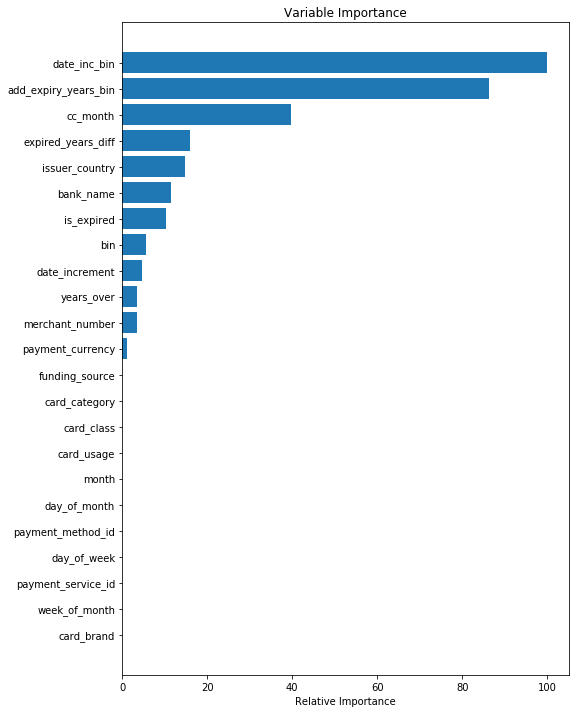

In [12]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
from src.web.preprocessing import *
from src.web.preprocessing import PreProcessing 
from src.web.train_util import *
classifier = XGBClassifier
scale_pos_weight = fail_size / success_size
tuned_parameters = None

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.13, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 6,
              'silent': 0,
              'subsample': 0.8,
              'colsample_bytree': 0.7,
              'n_estimators': 1000,
              'missing':-999,
              'seed': 1337,
              'scale_pos_weight': scale_pos_weight,
              'eval_metric': 'map',
              'gamma': 2  }

model_file = ''
model_id = 'ML-ECO-2'
version = get_latest_version(model_id, MODEL_TYPE) + 1
model_name = model_id + '.' + str(version)
features_dict['eval_metric'] = 'map'
xgb_clf, result_d = build_and_train(eco, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters, features_dict=features_dict)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


In [ ]:
result_d

In [ ]:
# """Upload model to Nexus repo and insert the model info into Cassandra table"""
# import json

# # start_date = '2018-01-01'
# start_date = '2019-01-01'

# end_date = '2019-05-31'

# try:
#     repo_path = upload_artifact(model_file_name)
#     preprocess_repo_path = handle_preprocessing_file(model_id, version)
#     size_desc = str(", original size: %s (fail: %s, success: %s), balanced_size: %s" % (original_size, fail_size, success_size, original_size))
#     desc = '{}_{}_for_eco model with date_inc_bin and added_years_bin. {}'.format(start_date, end_date, size_desc)
#     hyper_params = result_d.pop('hyper_params', None)
#     extended_att = {"preprocess_repo_path": preprocess_repo_path, "input_features": INPUT_FEATURES}
#     insert_model_info(model_id, version, repo_path, desc=desc, model_type=MODEL_TYPE,eval_metrics=json.dumps(result_d), 
#                       hyper_parameter=json.dumps(hyper_params), extended_att=json.dumps(extended_att), features_dict=features_dict)
    
# except:
#     if not hyper_params:
#         result_d['hyper_params'] = hyper_params 